In [17]:
import os
# Train autoencoder using keras tensorflow
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import sys
try:
    if changed:
        raise Exception("changed")
except NameError:
    changed = False
    sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
from data.generate_synthetic_data import generate_synthetic_sparse_signal, generate_kernel_h

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# parameters of signal 
length = 2000
sparsity = [0.05, 0.1, 0.2]
noise_level = [0.05, 0.1, 0.5]
kernel_types = ["identity", "deriv", "gaussian", "gaussian_heteroscedastic", "sparse_random", "hard_sparse_random"]

# number of samples to generate for each parameter combination
num_samples = 100

# parametes combinations
parameters = [(s, n, k) for s in sparsity for n in noise_level for k in kernel_types]
print(len(parameters))





54


In [16]:
# generate original_signal, noisy_signal, H for each parameter combination
train = {
    "original_signals": [],
    "noisy_signals": [],
    "Hs": []
}
validation = {
    "original_signals": [],
    "noisy_signals": [],
    "Hs": []
}
test = {
    "original_signals": [],
    "noisy_signals": [],
    "Hs": []
}

for s, n, k in parameters:
    for i in range(num_samples):
        if i < num_samples * 0.6:
            data = train
        elif i < num_samples * 0.8:
            data = validation
        else:
            data = test
        h = generate_kernel_h(length=50, type=k)
        degraded_signal, signal, H = generate_synthetic_sparse_signal(length=length, sparsity=s, noise_level=n, h=h)
        data["original_signals"].append(signal)
        data["noisy_signals"].append(degraded_signal)
        #data["Hs"].append(H)
# remove last 25 elements and first 25 elements from each noisy signal

train_noisy_signals = np.array(train["noisy_signals"])
train["noisy_signals"] = train_noisy_signals[:, 25:-25]
print(train["noisy_signals"].shape)
validation_noisy_signals = np.array(validation["noisy_signals"])
validation["noisy_signals"] = validation_noisy_signals[:, 25:-25]
print(validation["noisy_signals"].shape)

test_noisy_signals = np.array(test["noisy_signals"])
test["noisy_signals"] = test_noisy_signals[:, 25:-25]
print(test["noisy_signals"].shape)  



(3240, 2000)
(1080, 2000)
(1080, 2000)


In [23]:


# parameters
encoding_dim = 50
input_dim = len(train["original_signals"][0])
learning_rate = 0.001
batch_size = 32
epochs = 1000

# create deep autoencoder
input_signal = Input(shape=(input_dim,))
encoded = Dense(input_dim//2, activation='relu')(input_signal)
encoded = Dense(input_dim//4, activation='relu')(encoded)
decoded = Dense(input_dim//2, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_signal, decoded)
autoencoder.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='mse')
autoencoder.summary()




Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_18 (Dense)            (None, 1000)              2001000   
                                                                 
 dense_19 (Dense)            (None, 500)               500500    
                                                                 
 dense_20 (Dense)            (None, 1000)              501000    
                                                                 
 dense_21 (Dense)            (None, 2000)              2002000   
                                                                 
Total params: 5004500 (19.09 MB)
Trainable params: 5004500 (19.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:

# train autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpointer = ModelCheckpoint(filepath='model.h5', verbose=0, save_best_only=True)
history = autoencoder.fit(np.array(train["noisy_signals"]), np.array(train["original_signals"]),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(np.array(validation["noisy_signals"]), np.array(validation["original_signals"])),
                callbacks=[early_stopping],
                verbose=2) # 0 = silent, 1 = progress bar, 2 = one line per epoch.

Epoch 1/1000
102/102 - 12s - loss: 142.5653 - val_loss: 195.6636 - 12s/epoch - 122ms/step
Epoch 2/1000
102/102 - 11s - loss: 141.1839 - val_loss: 195.8459 - 11s/epoch - 112ms/step
Epoch 3/1000
102/102 - 10s - loss: 141.4721 - val_loss: 195.5367 - 10s/epoch - 101ms/step
Epoch 4/1000
102/102 - 11s - loss: 140.5477 - val_loss: 195.4353 - 11s/epoch - 104ms/step
Epoch 5/1000


KeyboardInterrupt: 

In [ ]:
# plot results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



34/34 [==============================] - 0s 11ms/step
(1080, 2000)


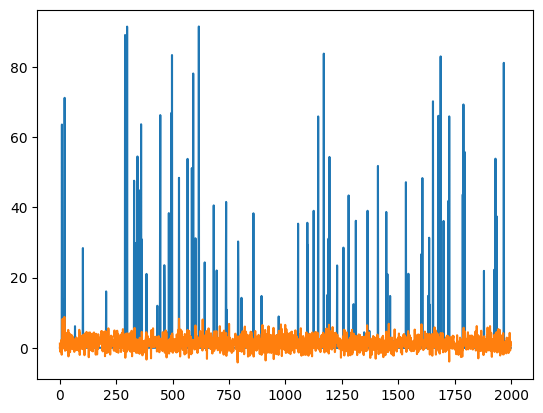

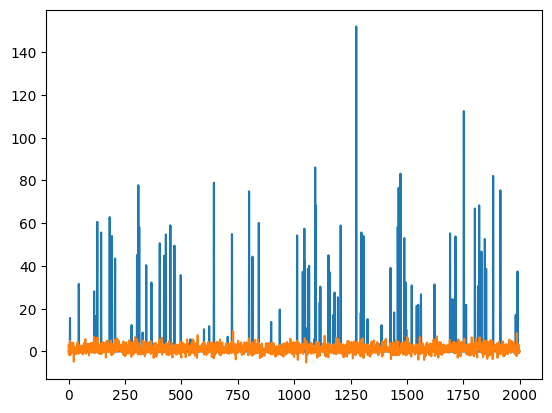

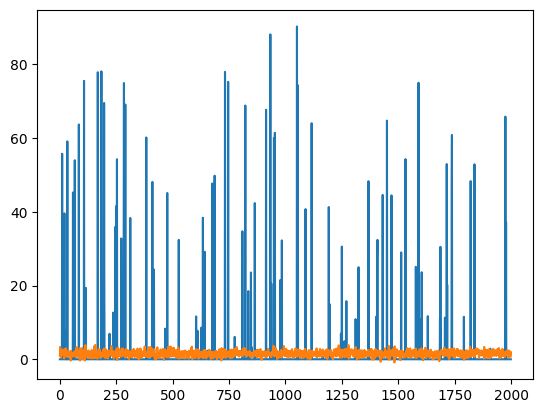

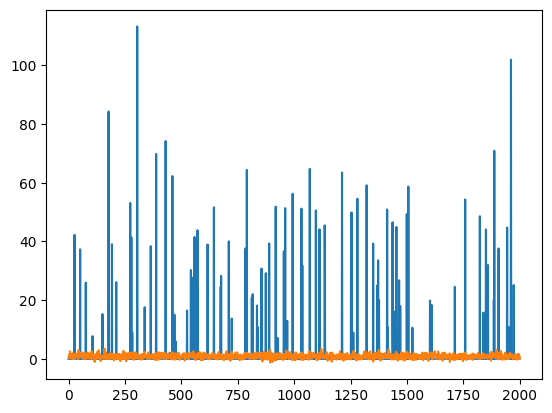

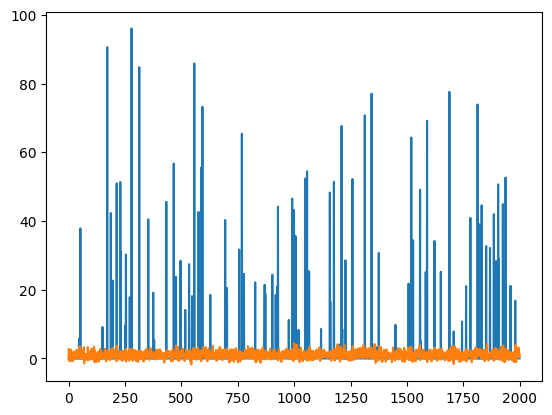

In [25]:
#compare original and denoised signals
decoded_signals = autoencoder.predict(np.array(test["noisy_signals"]))
print(decoded_signals.shape)
for i in range(5):
    plt.plot(test["original_signals"][i])
    plt.plot(decoded_signals[i])
    plt.show()